# Model Training

In this notebooks, we formulate a multi-class classification problem as follows:

> Is a machine going to need maintenance within the next N cycles, and if yes, due to what type of a failure?

First, we define the future horizon:

In [1]:
w = 7 # future horizon (cycles)

%matplotlib inline
import glob
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from pathlib import Path

data_dir = str(Path.home()) + '/data'

## Reading input data

In [2]:
filenames = glob.glob(data_dir + '/features/*.csv')
converters={"failure": str}
seed = 42
dfs= [pd.read_csv(filename, converters=converters) for filename in filenames]
data = pd.concat(dfs, ignore_index=True)

## Train/test split

Two split strategies are implemented below:
* time-dependent split
* asset ID-based split

Time-dependent split is more complex as it requires that training and test data sets don't have common rolling feature time frames. This means that for all sequences in the test data set, $X$ immediately preceding entries need to be removed from the training data, where $X$ is the length of the rolling aggregation window used during feature engineering minus 1 [[2]](#ref_2).

In [3]:
lookback = 5       # rolling aggregation interval during feature engineering
test_size = 0.2
time_split = False  # if set to False, will perform asset ID-based split

if time_split:
    data.set_index(['entryID'], inplace=True)
    data.sort_index(inplace=True)

    train, test = train_test_split(data, test_size=test_size, shuffle=False)
    
    min_cycles = test.reset_index().groupby(
        ['machineID']
    ).cycle.min().apply(lambda x: x - lookback).to_frame(name='max_cycle')
    
    t = train.reset_index().join(min_cycles, on='machineID')
    train = t[t.max_cycle.isna() |
              (t.cycle < t.max_cycle)].drop('max_cycle', axis=1)
    train.set_index(['entryID'], inplace=True)
else:
    # asset ID-based split
    unique_assets = data.reset_index().machineID.unique()
    train_assets, test_assets = train_test_split(
        unique_assets, test_size=test_size, random_state=seed)
    train = data[data.machineID.isin(train_assets)]
    test = data[data.machineID.isin(test_assets)]
    train.set_index(['entryID'], inplace=True)
    test.set_index(['entryID'], inplace=True)

### Label assignment

The input feature data set provides remaining useful life (RUL) labels for all sequences ending in a failure. Below, RUL is translated into multi-class labels as follows:

$$
L_i = \left\{
\begin{array}{ll}
      F_i & rul_i\leq w \\
      \emptyset & \text{otherwise} \\
\end{array} 
\right.
$$

where $F_i$ is the type of the failure which ends the sequence the entry is a part of, $rul_i$ is the remaining useful life assigned to the entry, and $w$ is the future horizon.

In [4]:
def xy(data, w):
    data = data.reset_index(drop = True)
    f = lambda row: row.failure if row.rul and row.rul < w else ''
    columns_to_drop = ['cycle', 'failure', 'rul', 'sequenceID', 'machineID']
    return (data.drop(columns_to_drop, axis=1),
            data.apply(f, axis=1))

X_train, Y_train = xy(train, w)
X_test, Y_test = xy(test, w)

### Correction of data imbalance

In typical predictive maintenance data sets, positive examples as often underrepresented relative to negative examples. This can be seen by counting failure types in the "ground truth" training data set:

In [5]:
all_classes = Counter(Y_train)
majority_class = all_classes.most_common(1)
minority_classes = all_classes.most_common()[1:]

print('Majority class: ', majority_class)
print('Minority classes: ', minority_classes)

Majority class:  [('', 51971)]
Minority classes:  [('F1', 924), ('F2', 384)]


With class imbalance in data, performance of most standard learning algorithms is compromised, since they aim to minimize the overall error rate. For a data set with 99% negative and 1% positive examples, a model can be shown to have 99% accuracy by labeling all instances as negative. But the model will mis-classify all positive examples; so even if its accuracy is high, the algorithm is not a useful one.

Here, we will use the Synthetic Minority Over-sampling Technique (SMOTE) [[3]](#ref_3) to produce a more balanced training data set with at least 10% of positive examples. Note that over-sampling is not applied to the test data set.

In [6]:
minority_classes_size = sum([c[1] for c in minority_classes])
desired_minority_classes_size = Y_train.count() * 0.1

scale = desired_minority_classes_size / minority_classes_size

ratio = None
if scale > 1:
    ratio = dict((c[0], int(c[1] * scale)) for c in minority_classes)

sm = SMOTE(ratio=ratio, random_state=seed)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)
Counter(Y_train_res)

Counter({'': 51971, 'F1': 3763, 'F2': 1564})

## Model training

In [7]:
clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train_res, Y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Model evaluation

**Note: this section is unfinished and needs more work**

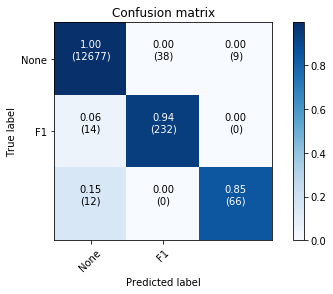

In [8]:
Y_predictions = clf.predict(X_test)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    orig = cm
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt) + '\n({0})'.format(orig[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(Y_test, Y_predictions)
plot_confusion_matrix(cm, ['None', 'F1'])

In [9]:
# Not a very useful score
accuracy_score(Y_test, Y_predictions)

0.9944052728387492

## Persisting the model and input sample

In [10]:
from sklearn.externals import joblib
joblib.dump(clf, 'model.pkl') 

['model.pkl']

In [11]:
sample = X_test.sample(n = 5).to_json(orient='records')
print('Sample:', sample)

with open('sample.json', 'w') as sample_file:
    sample_file.write(sample)

Sample: [{"s1":1000,"s2":761.1411666667,"s3":136.0233333333,"s4":136.12,"s5":1114.0608333333,"s6":1592.62,"s7":135.9904490741,"s8":136.0866666667,"s9":1245.0425694444,"s10":1593.2816666667},{"s1":1000,"s2":934.78475,"s3":146.8305,"s4":146.97,"s5":1019.85525,"s6":1229.35,"s7":146.458775,"s8":146.6166666667,"s9":999.5446986111,"s10":1239.4733333333},{"s1":1000,"s2":935.14625,"s3":159.39625,"s4":159.81,"s5":769.0573333333,"s6":938.07,"s7":156.966537963,"s8":157.4616666667,"s9":848.2114305556,"s10":991.1016666667},{"s1":1000,"s2":1038.1156111111,"s3":137.1442222222,"s4":137.26,"s5":1427.3506666667,"s6":1602.01,"s7":137.0883634259,"s8":137.195,"s9":1356.4581805556,"s10":1602.3716666667},{"s1":1000,"s2":1368.2648666667,"s3":153.6534,"s4":154.2,"s5":1454.4247666667,"s6":1650.54,"s7":152.5318305556,"s8":152.83,"s9":1221.8341208333,"s10":1510.045}]


## References

https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance

https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance#time-dependent-split

https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html